In [1]:
from pathlib import Path

import yaml
import polars as pl
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import scienceplots

In [2]:
plt.style.use(['science','ieee'])

In [3]:
window_size = 100

---

In [24]:
paths = [
    path.parent
    for path in Path('../sweep/n_episodes_1001').glob('**/**/cartp__times.csv')
]
len(paths)

18

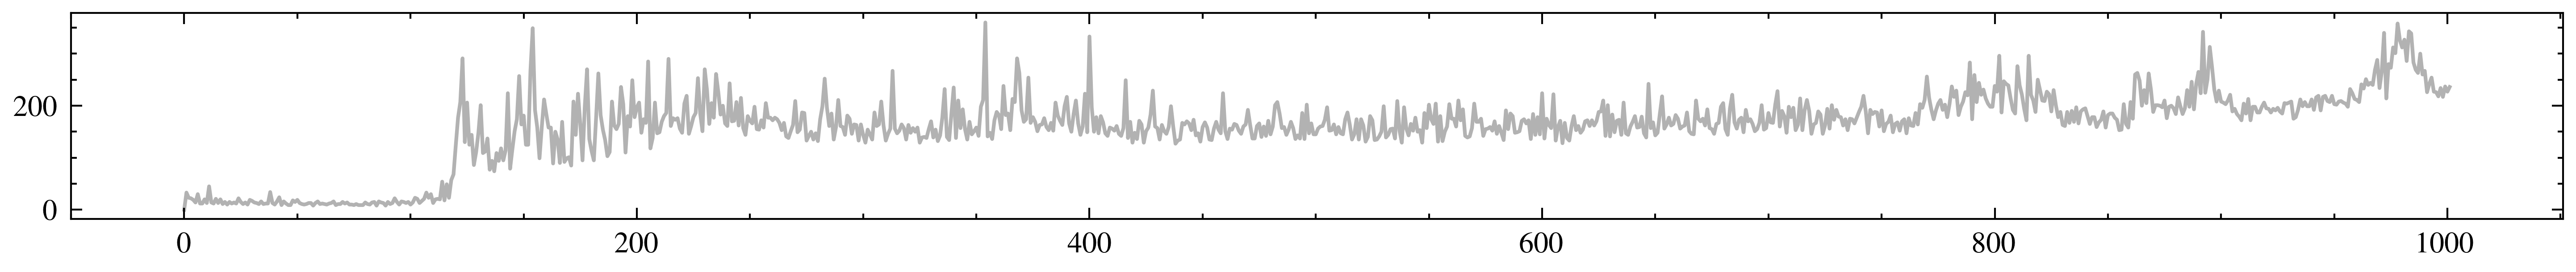

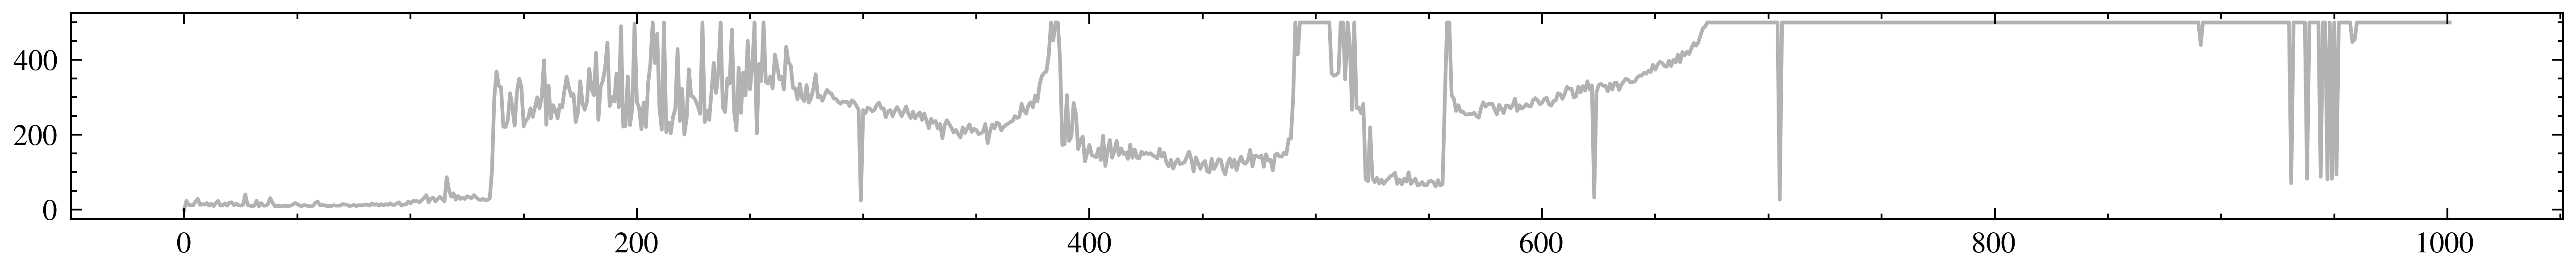

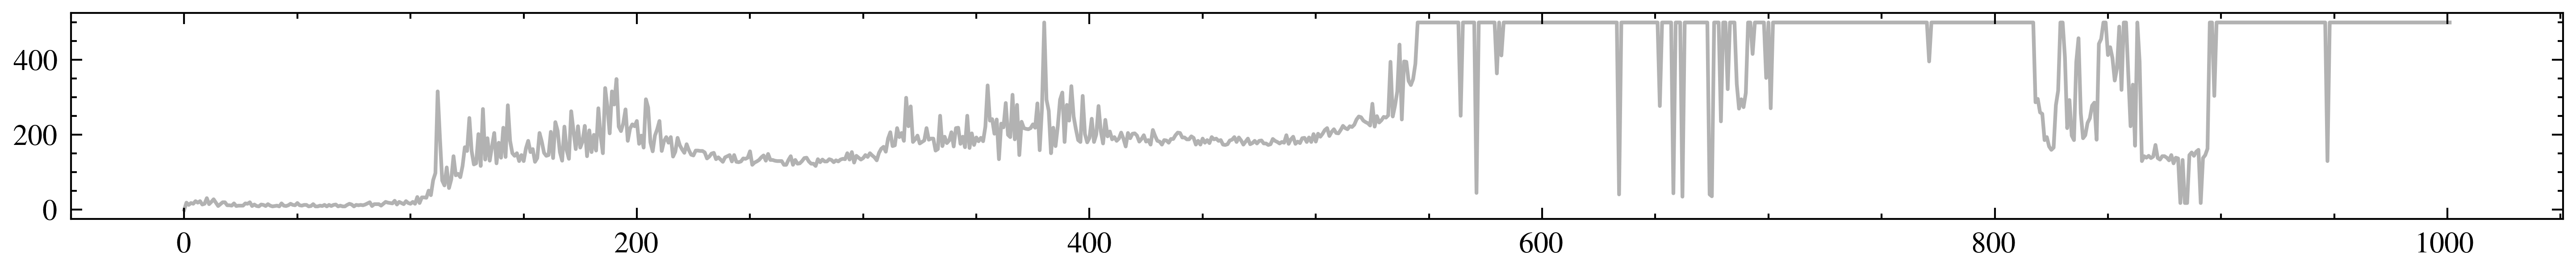

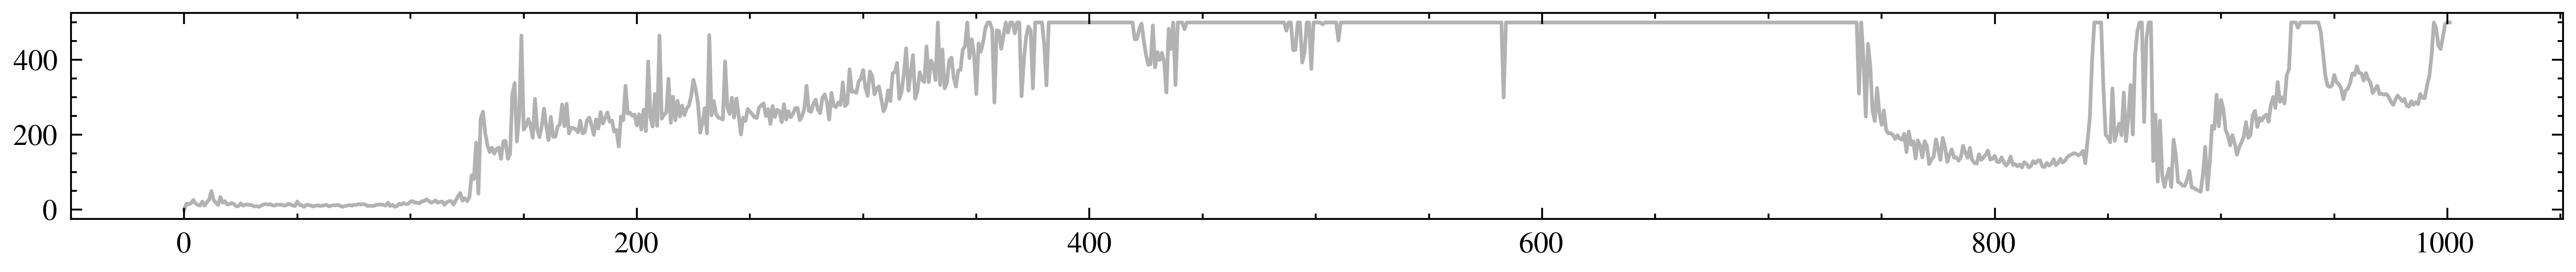

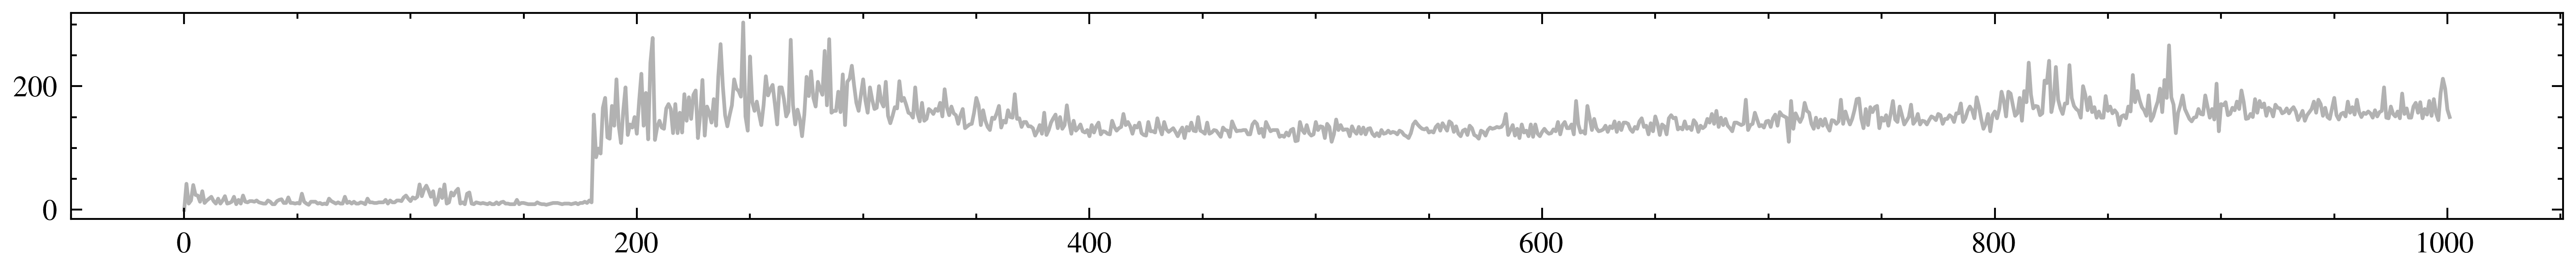

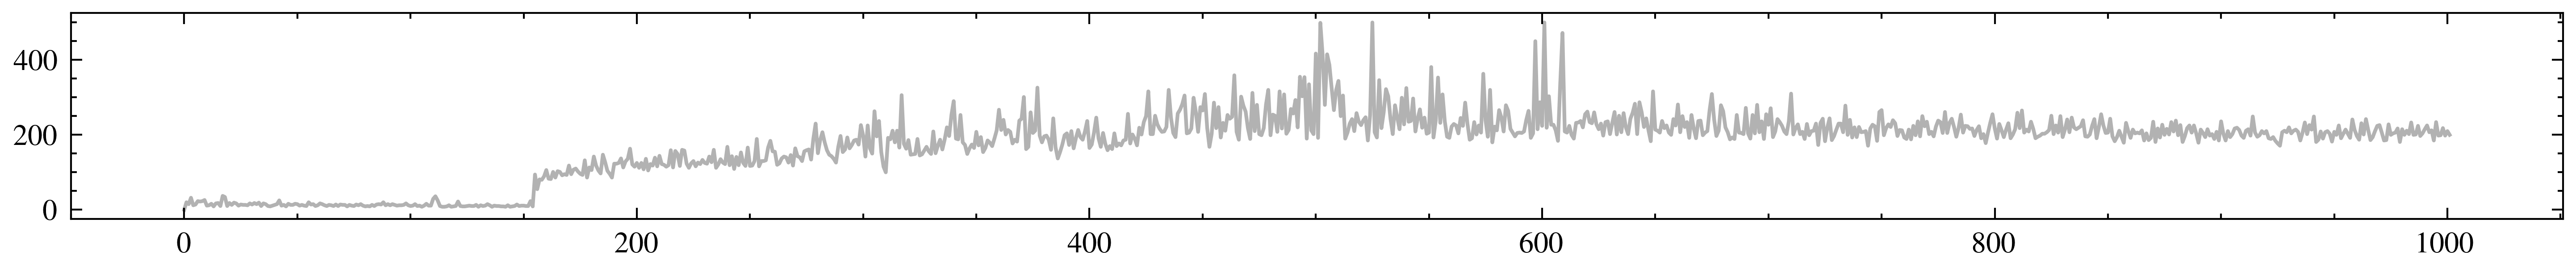

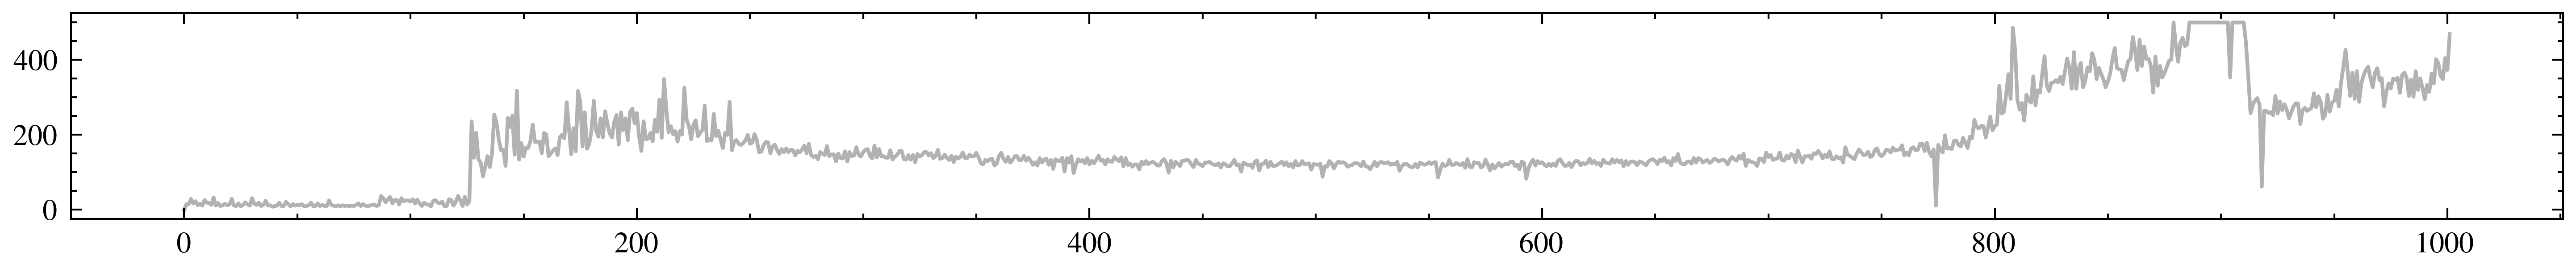

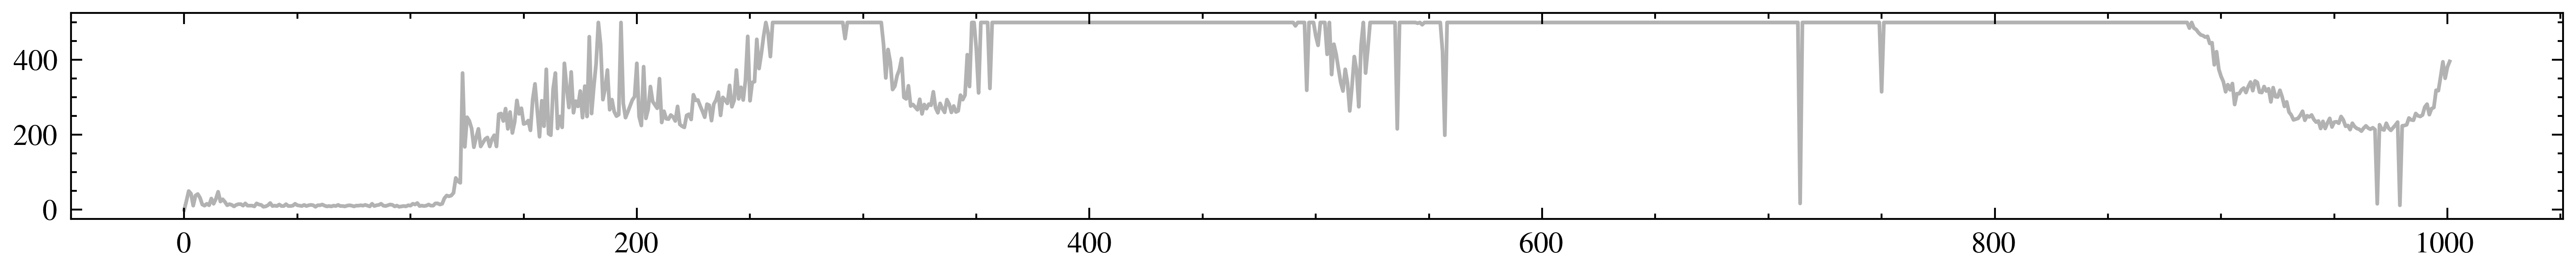

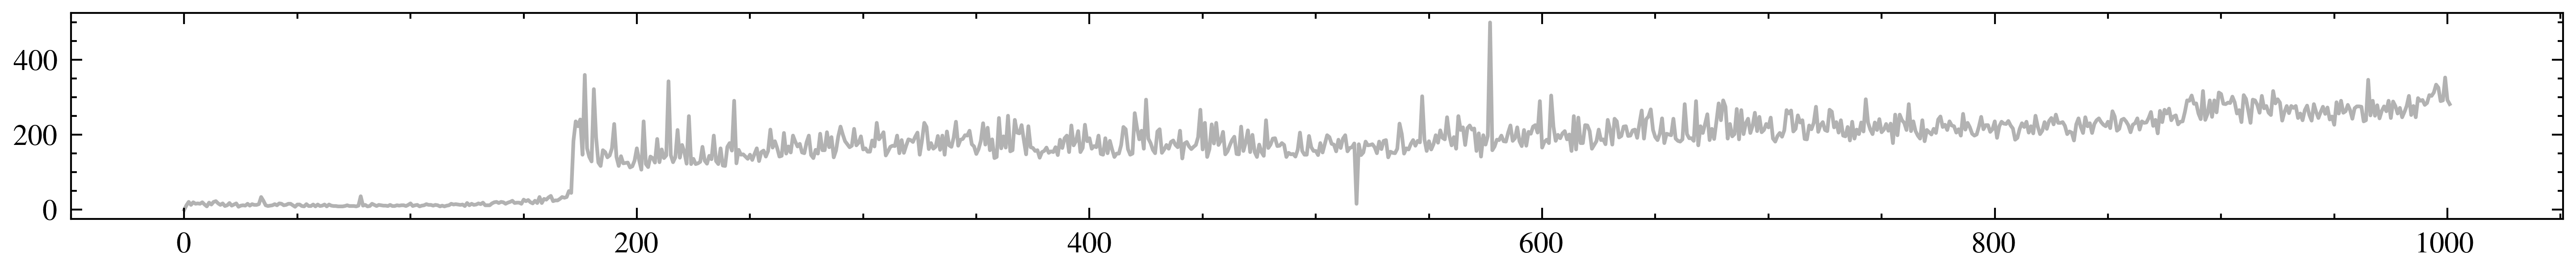

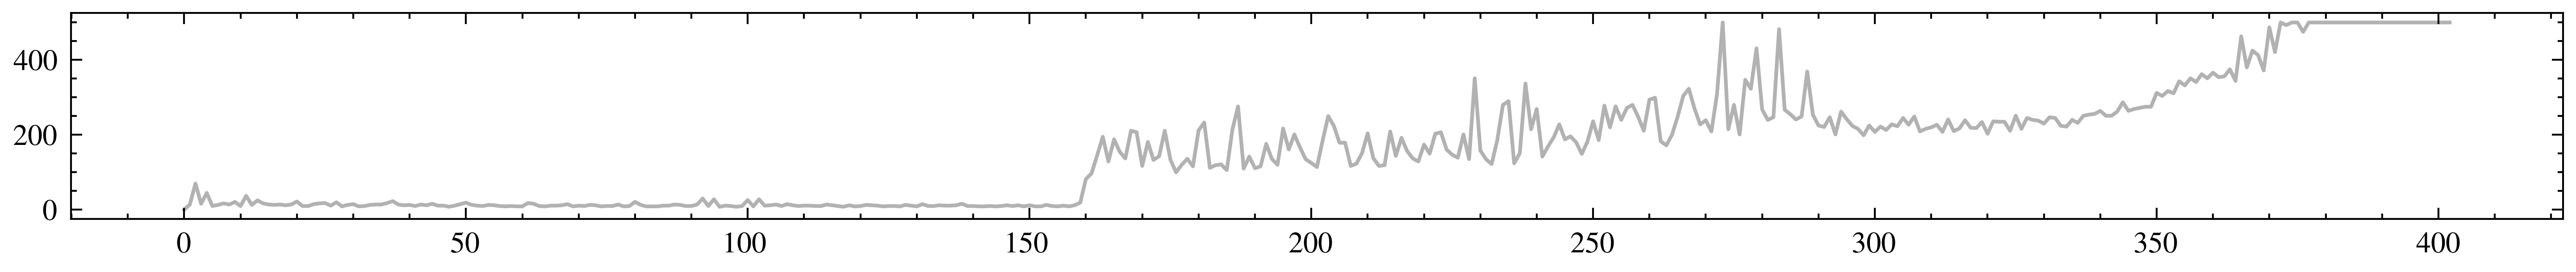

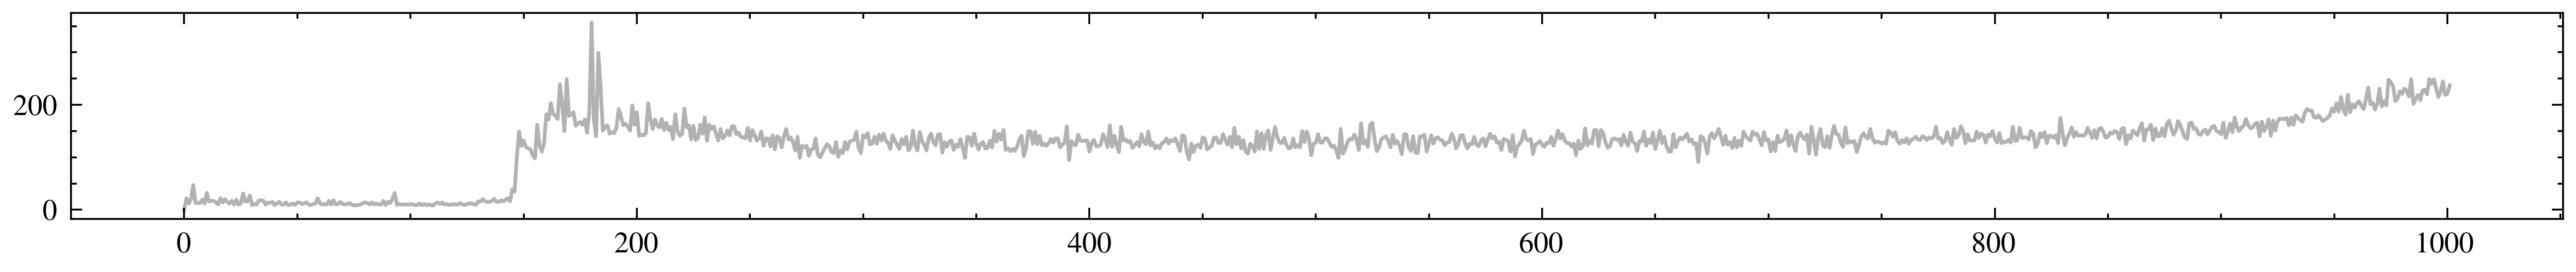

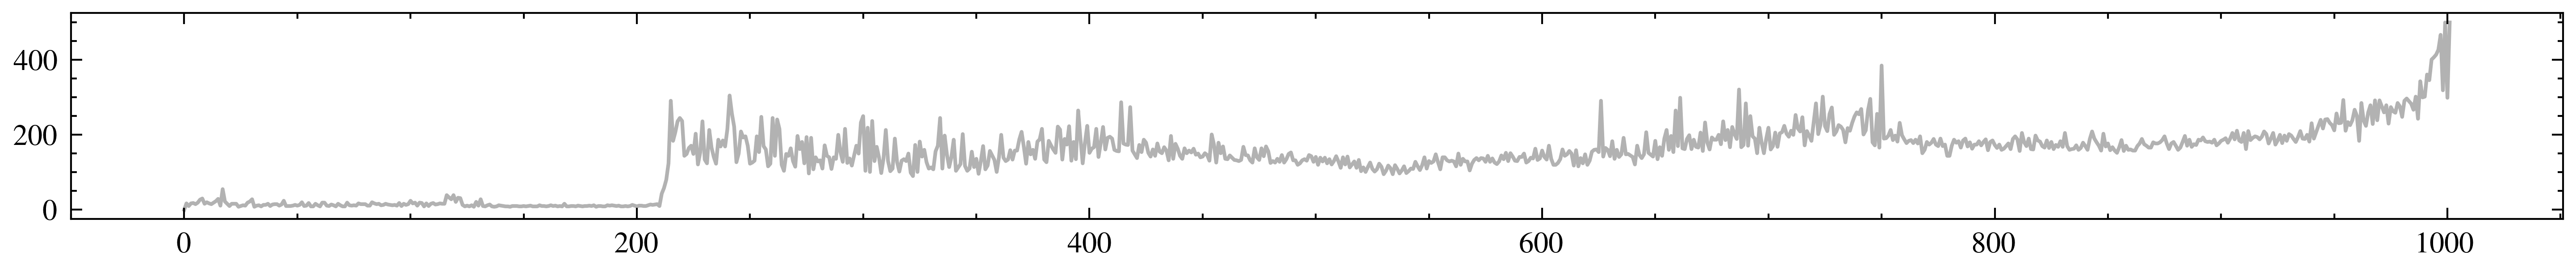

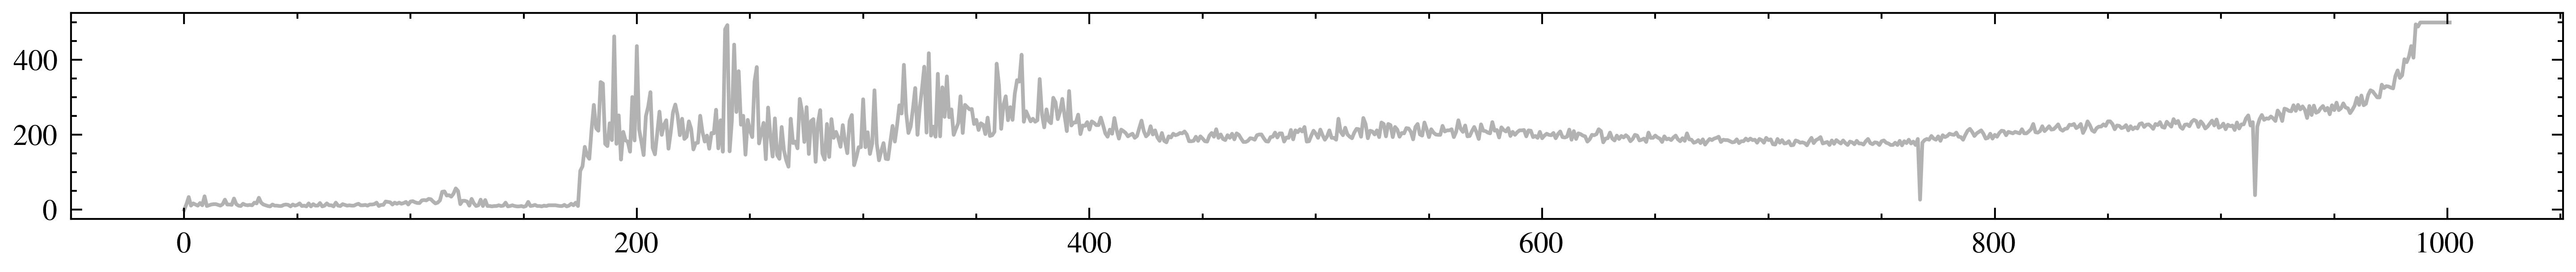

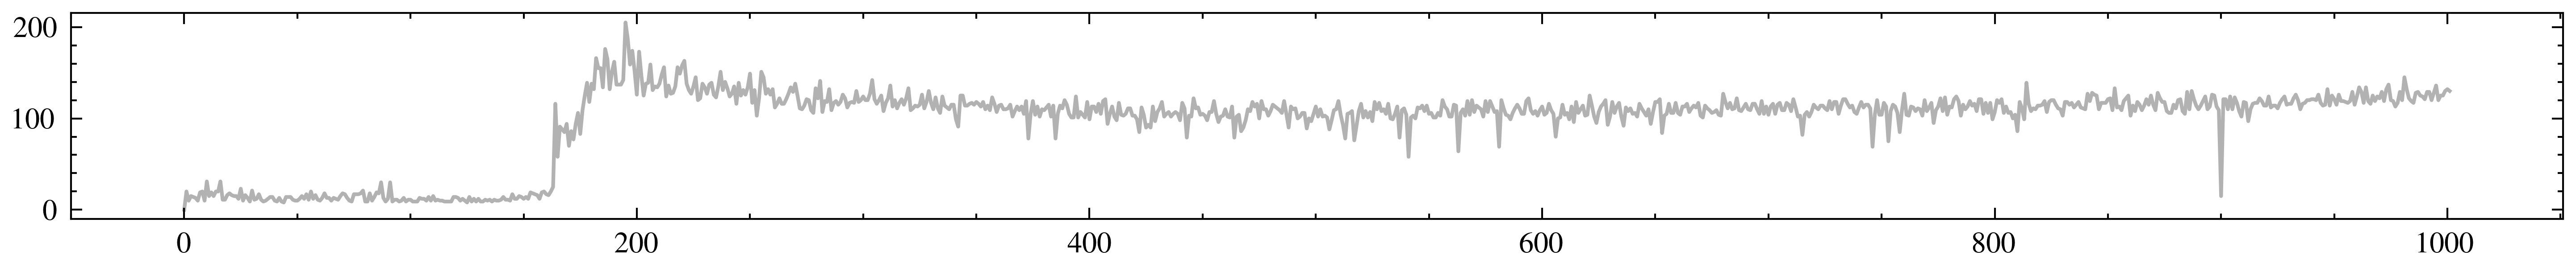

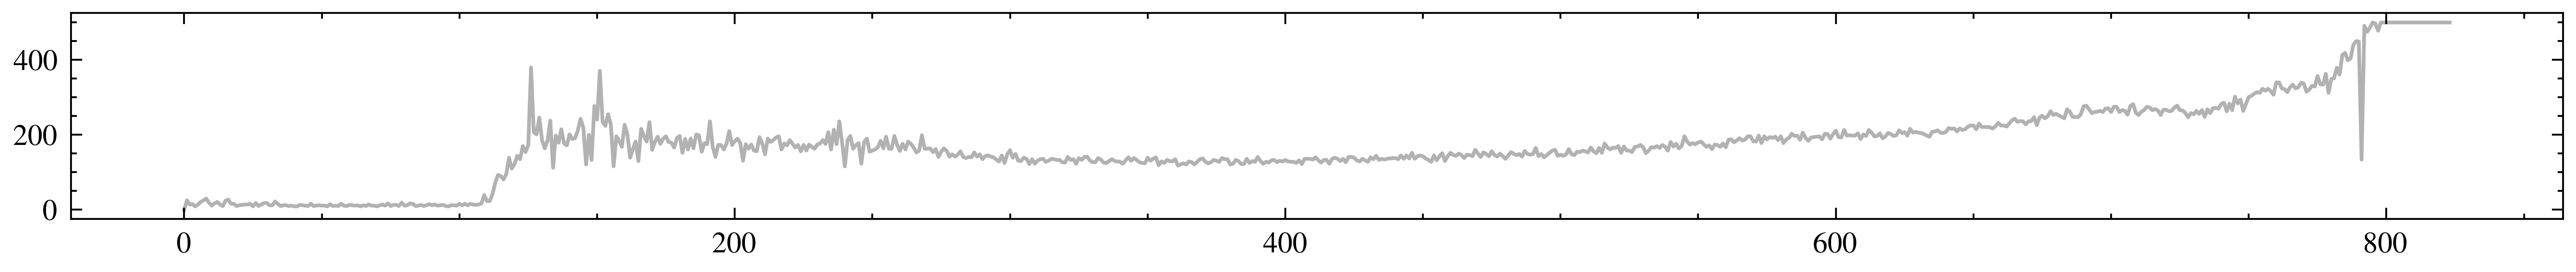

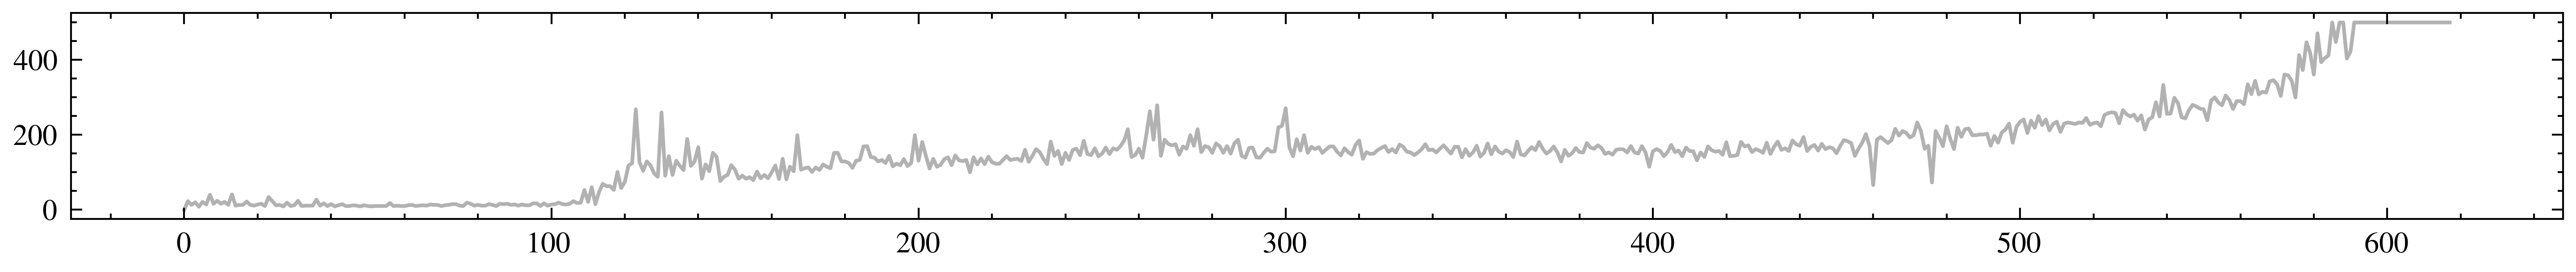

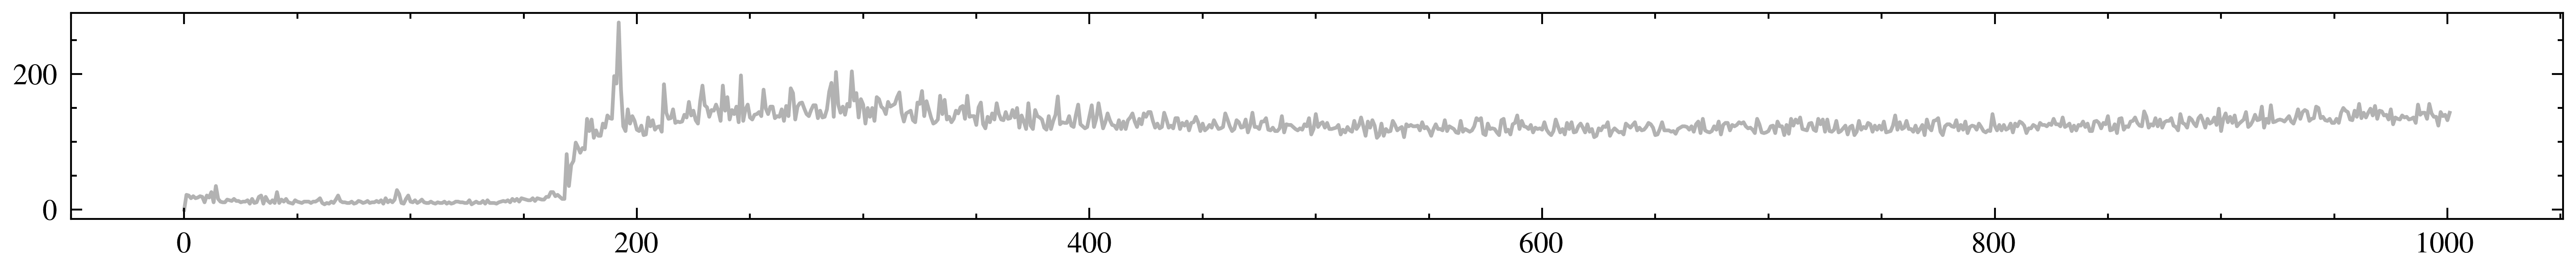

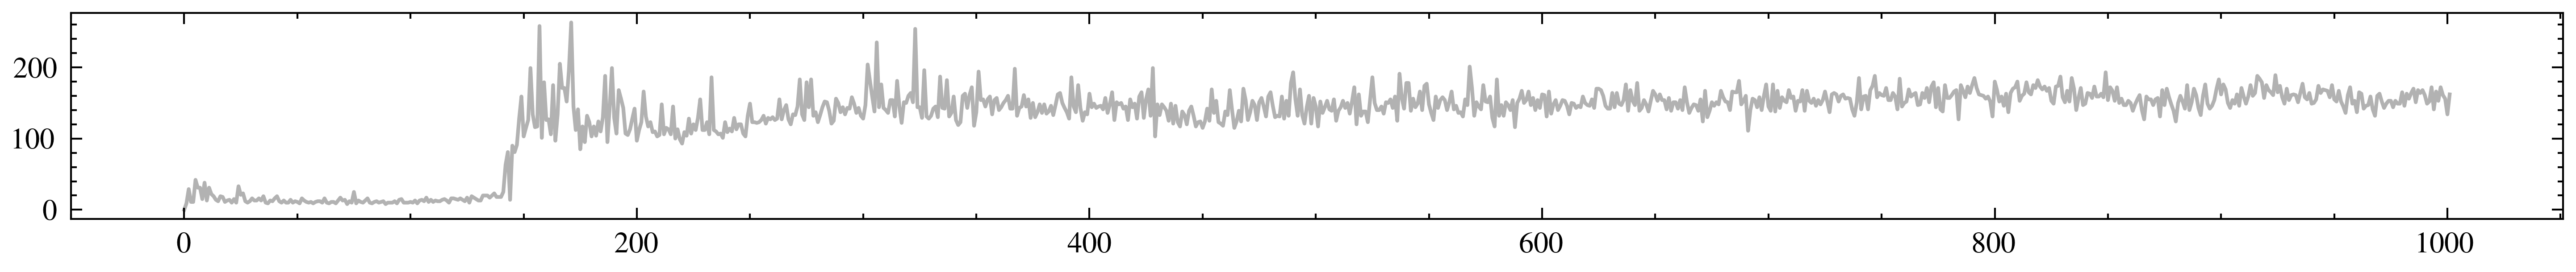

In [25]:
for path in paths:
    plt.figure(figsize=(12, 1))
    plt.plot(
        pl.read_csv(Path(path) / 'cartp__times.csv', has_header=False)
        .select('column_1')
        .to_series(),
        alpha=0.3, color='black', ls='solid'
    )
    plt.show()
    plt.close()

In [26]:
def read_times(path_: str, idx: int):
    filepath = Path(path_) / 'cartp__times.csv'
    aux = pl.read_csv(filepath, has_header=False)
    return (
        aux
        .rename({'column_1': 'times'})
        .with_columns(
            runid=pl.lit(f'exec_{idx:02d}'),
            order=pl.int_range(0, aux.shape[0]),
            path=pl.lit(str(filepath)),
        )
    )

In [27]:
times = (
    pl.concat(
        [read_times(elem, i)
        for i, elem in enumerate(paths)]
    )
    .filter(pl.col('order') < 1001)
    .with_columns(
        times_roll=(
            pl.col('times')
            .rolling_mean(window_size=window_size, closed='both', min_periods=1)
            .over('runid')
        )
    )
)

In [28]:
import os
os.environ['POLARS_FMT_STR_LEN'] = '156'

In [35]:
eval_perf = (
    times
    .with_columns(is_top=pl.col('times') > 400)
    .group_by('path')
    .agg(pl.sum('is_top').alias('count_top'))
    .sort('path')
)
eval_perf

path,count_top
str,u32
"""../sweep/n_episodes_1001/20231203T131746/0/cartp__times.csv""",0
"""../sweep/n_episodes_1001/20231203T131746/1/cartp__times.csv""",26
"""../sweep/n_episodes_1001/20231203T131746/2/cartp__times.csv""",1
"""../sweep/n_episodes_1001/20231203T131746/3/cartp__times.csv""",6
"""../sweep/n_episodes_1001/20231203T131746/4/cartp__times.csv""",39
"""../sweep/n_episodes_1001/20231203T131746/5/cartp__times.csv""",38
"""../sweep/n_episodes_1001/20231203T131746/6/cartp__times.csv""",0
"""../sweep/n_episodes_1001/20231203T131746/7/cartp__times.csv""",0
"""../sweep/n_episodes_1001/20231203T131746/8/cartp__times.csv""",0


In [36]:
best_run_path = (
    eval_perf
    .slice(offset=-1, length=1)
    .select('path')
    .item()
)

best_run = (
    pl.read_csv(best_run_path, has_header=False)
    .with_columns(
        order=pl.int_range(0, 1002),
    )
)

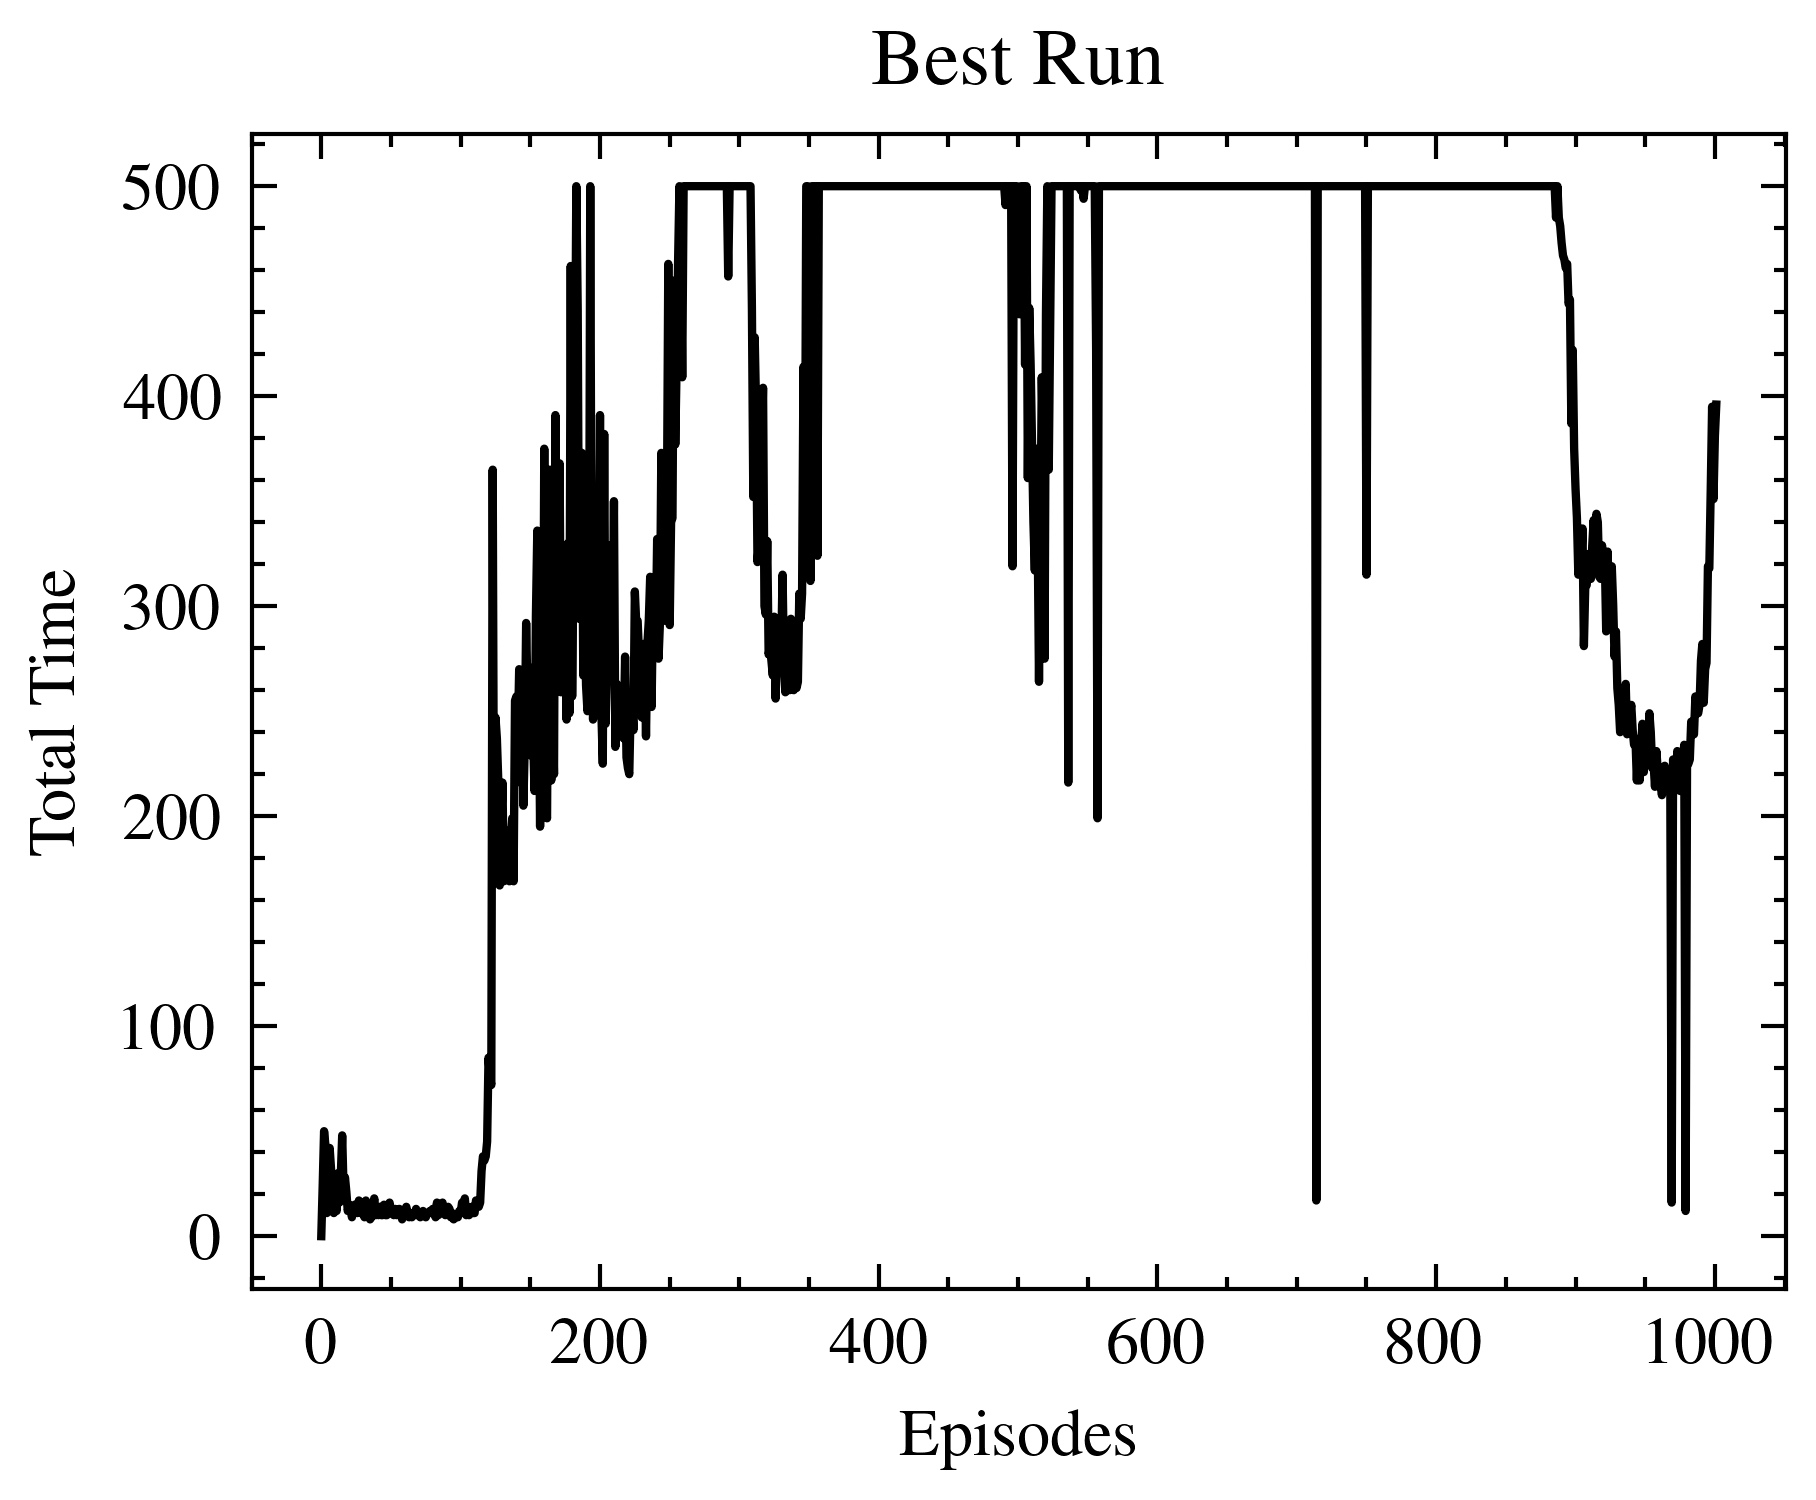

In [37]:
plt.plot(
    best_run
    .select('column_1')
    .to_series()
)

plt.title('Best Run')
plt.ylabel('Total Time')
plt.xlabel('Episodes')
plt.show()
plt.close()

In [38]:
worst_run_path = (
    eval_perf
    .slice(offset=0, length=1)
    .select('path')
    .item()
)

worst_run = (
    pl.read_csv(worst_run_path, has_header=False)
    .with_columns(
        order=pl.int_range(0, 1002),
    )
)

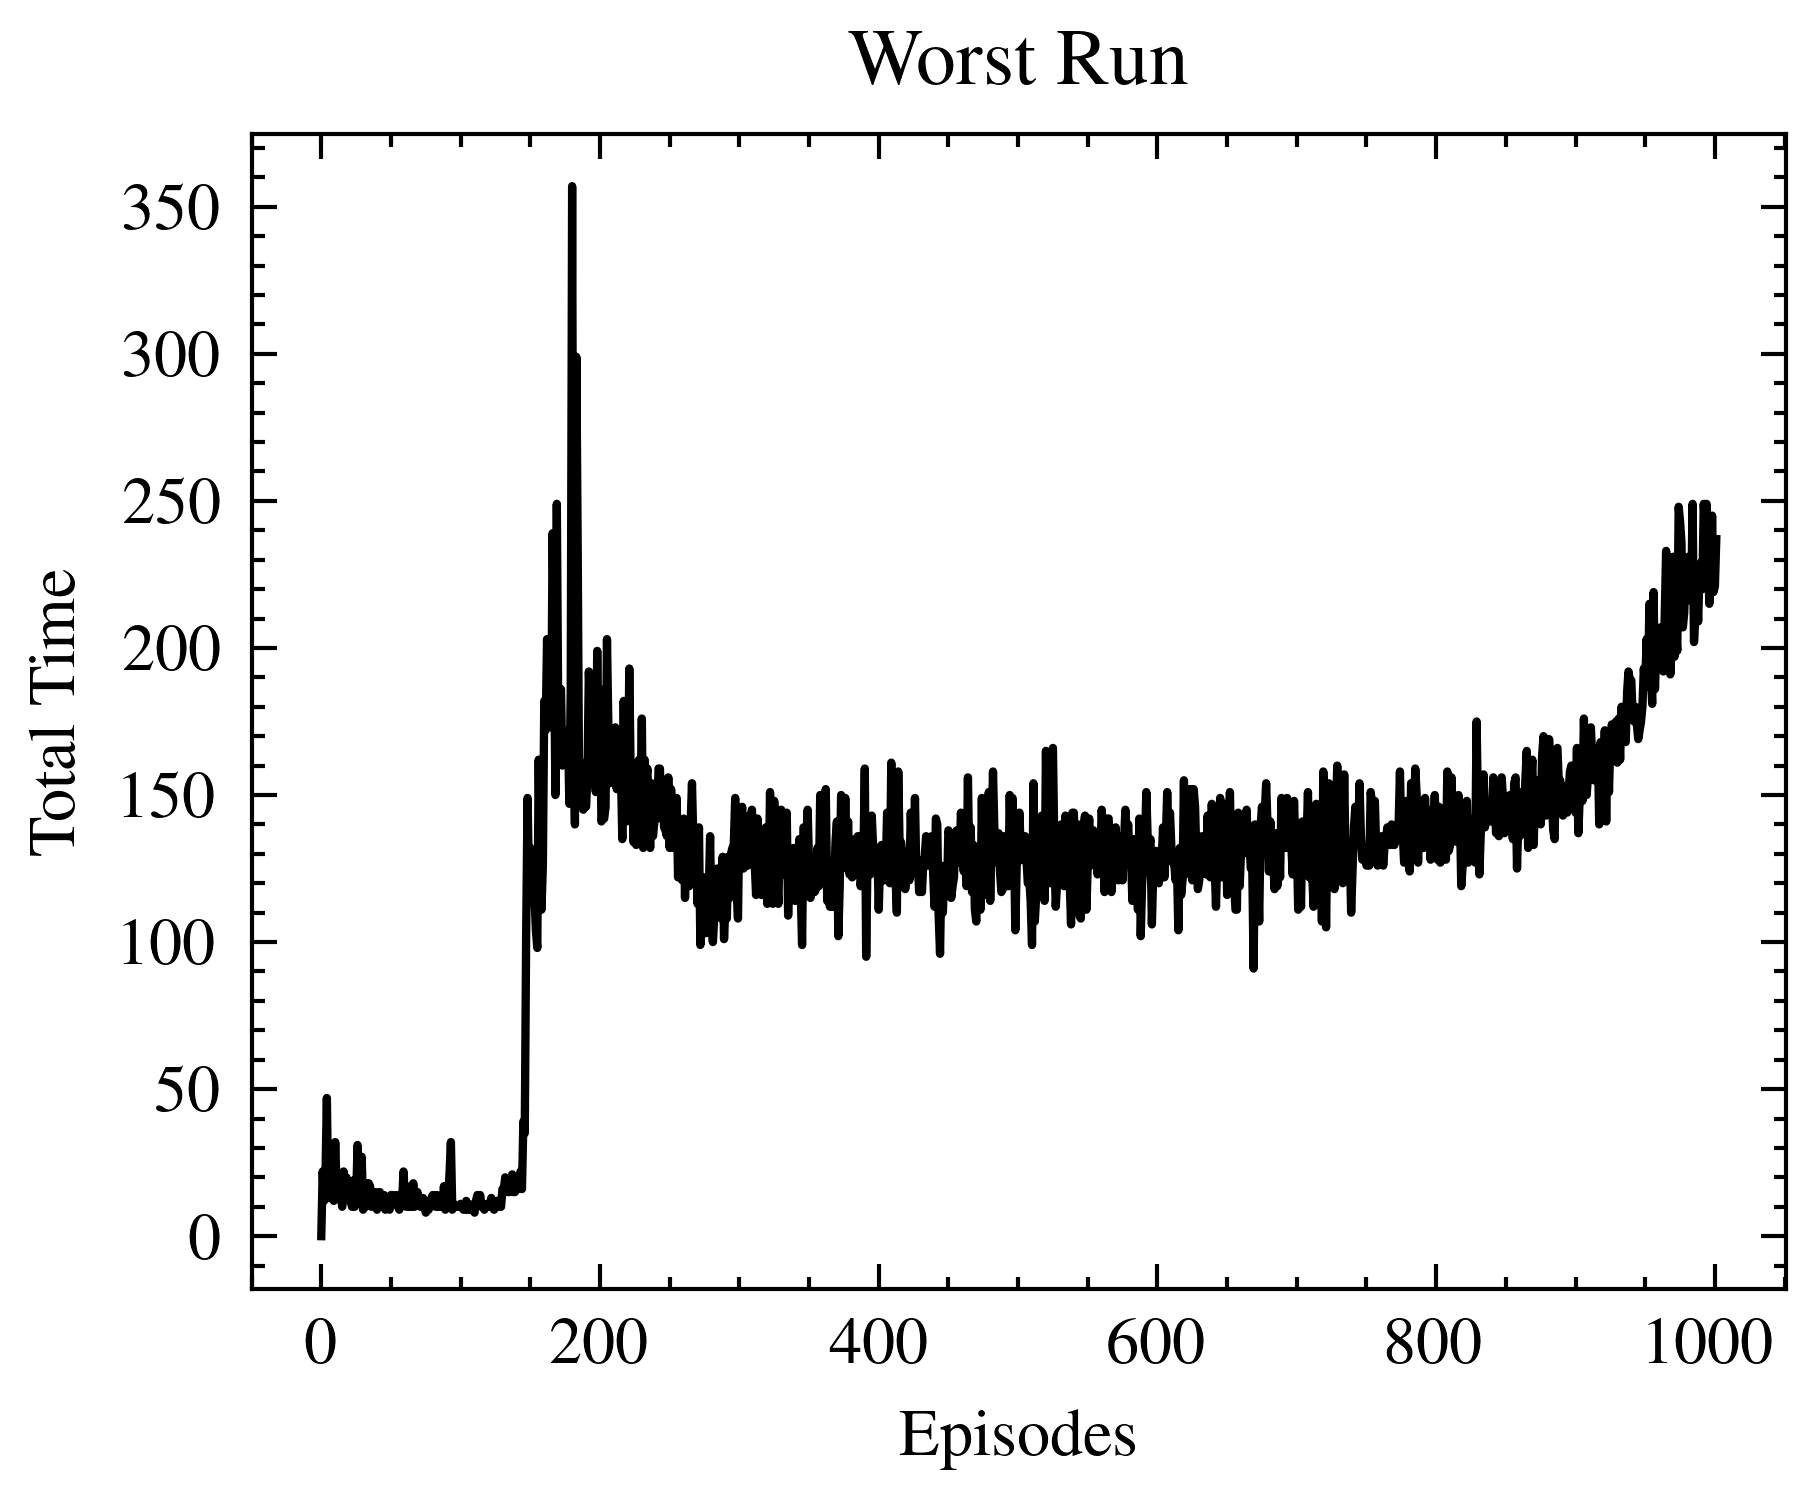

In [44]:
plt.plot(
    worst_run
    .select('column_1')
    .to_series()
)

plt.title('Worst Run')
plt.ylabel('Total Time')
plt.xlabel('Episodes')
plt.show()
plt.close()

In [42]:
times_grouped = (
    times
    .group_by('order')
    .agg(
        pl.count('times_roll').alias('count'),
        pl.mean('times_roll').alias('mean'),
        pl.std('times_roll').alias('std'),
    )
    .sort('order')
    .with_columns(
        mean_roll=(
            pl.col('mean')
            .rolling_mean(window_size=window_size, closed='both', min_periods=1)
        ),
        std_roll=(
            pl.col('std')
            .rolling_mean(window_size=window_size, closed='both', min_periods=1)
        )
    )
    .with_columns(
        top=pl.col('mean_roll') + pl.col('std_roll'),
        bot=pl.col('mean_roll') - pl.col('std_roll'),
    )
)

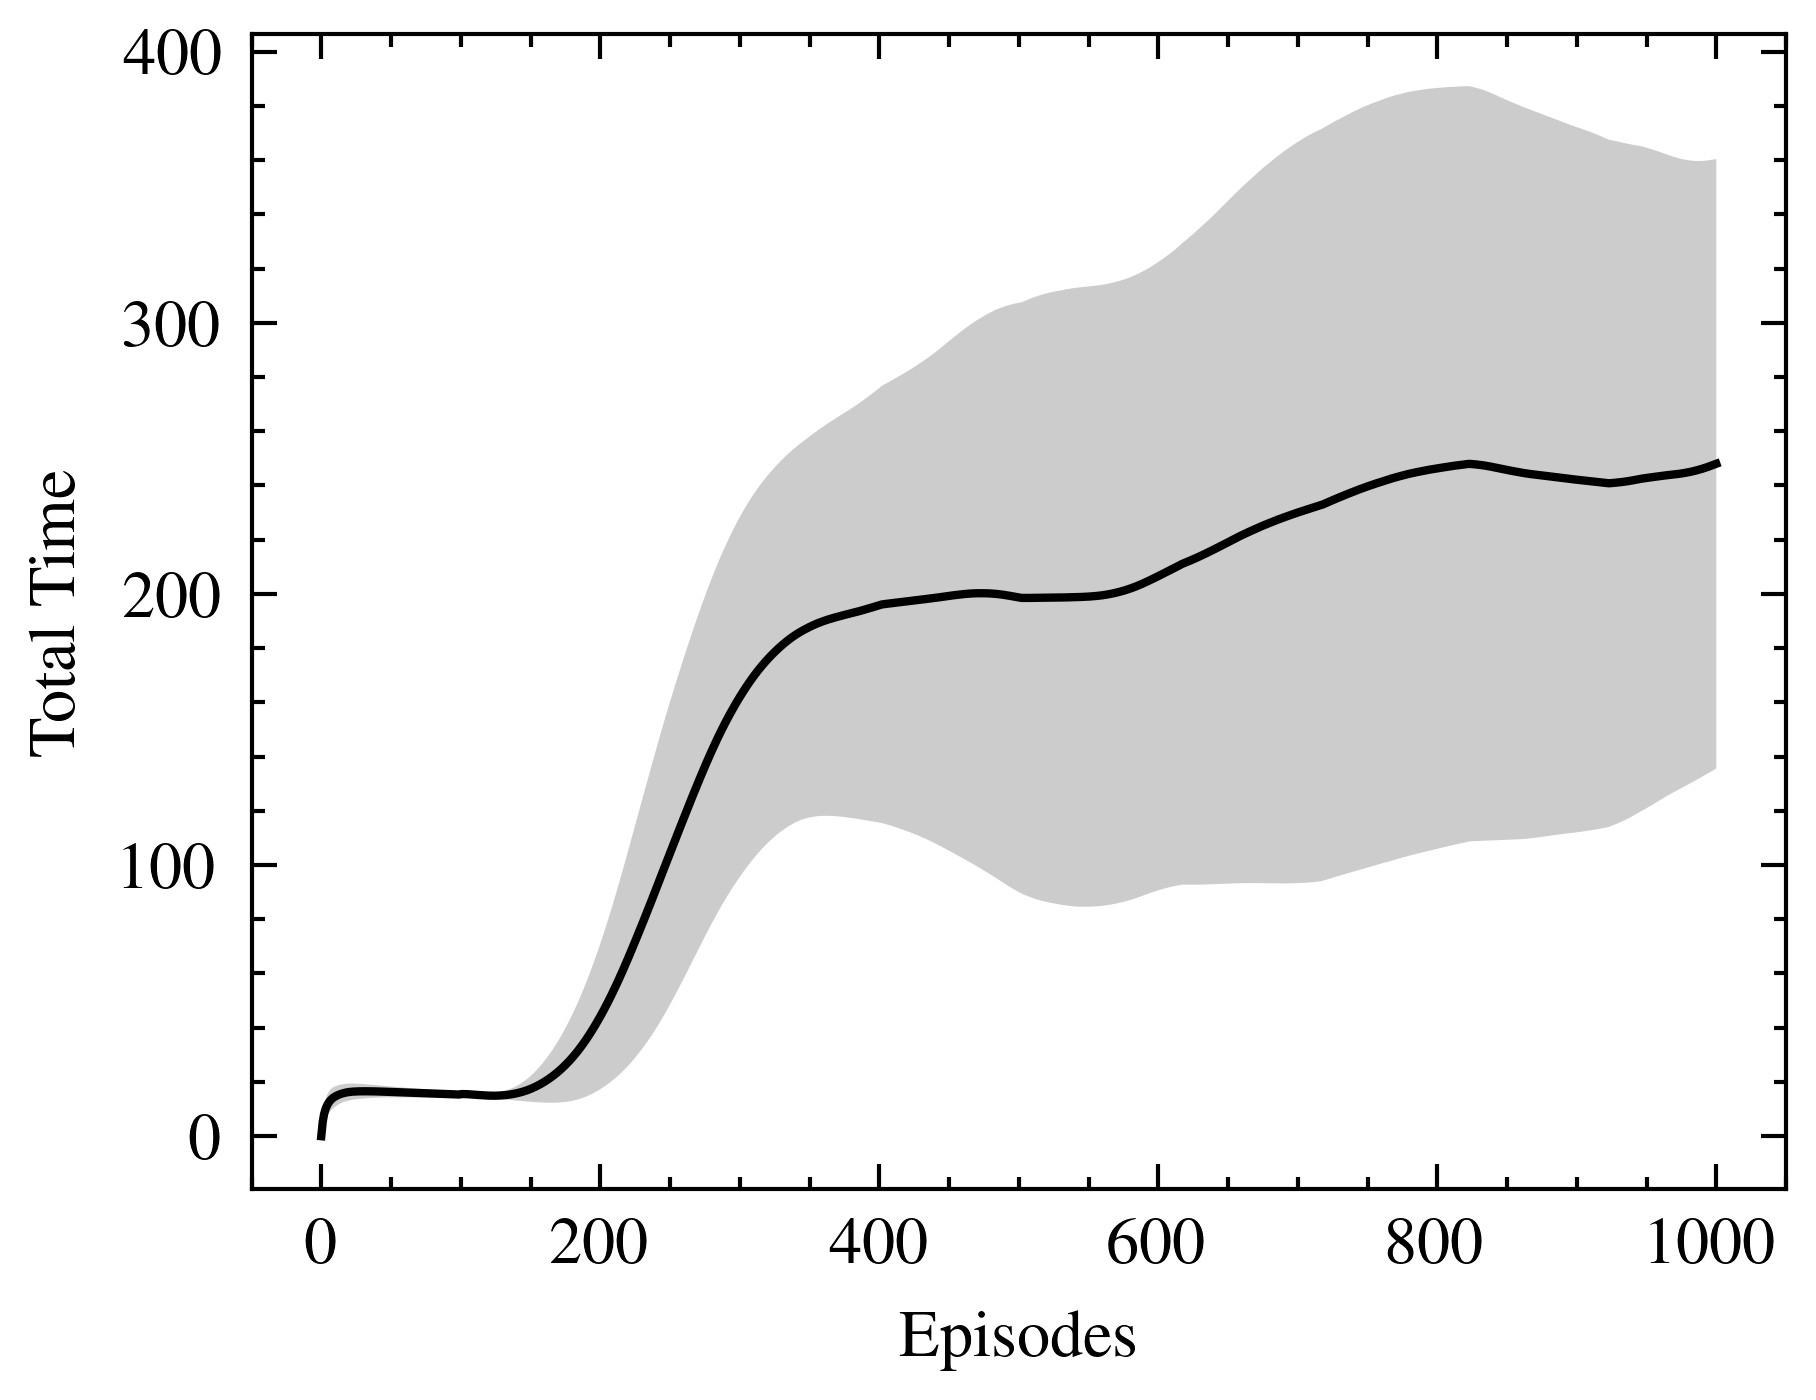

In [43]:
ax = plt.gca()

ax.plot(
    times_grouped.select('order').to_series(),
    times_grouped.select('mean_roll').to_series(),
)
ax.fill_between(
    x=times_grouped.select('order').to_series(),
    y1=times_grouped.select('bot').to_series(),
    y2=times_grouped.select('top').to_series(),
    alpha=.2,
)

plt.ylabel('Total Time')
plt.xlabel('Episodes')
# plt.title(title)
plt.show()
plt.close()

---